# Importing libraries

In [1]:

#!/usr/bin/env python

# testing face alignment, as on learnopencv.com
# cd Desktop/CMU/"Face Alignment"/FaceAverage

#Amogh description of this file: used to debug changes in the landmarks and the faces. To be run in Python 2.7 environment. 
import os
import cv2
import numpy as np
import math
import sys

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Copying landmark files to calculate the average landmarks

Code below in raw to avoid copying again

'E:/CMU/approach1_april_10/data/CK+/cohn-kanade-images/' now has landmark files and png files as well

# Defining helper functions for aligning images

In [5]:
# Read points from text files in directory
def readPoints(path) :
#     print 'trying to read points from ', path
    # Create an array of array of points.
    pointsArray = [];

    #List all files in the directory and read points from text files one by one
#     for filePath in os.listdir(path):
        
#         if filePath.endswith("Image-20.jpg.txt"):
            
            #Create an array of points.
    points = [];            
            
            # Read points from filePath
    with open(path) as file :
        for line in file :
            x, y = line.split()
            points.append((int(float(x)), int(float(y))))

    # Store array of points
    pointsArray.append(points)
            
    return pointsArray;

# Read all jpg images in folder.
def readImages(path) :
#     print 'trying to read points from: ', path
    #Create array of array of images.
    imagesArray = [];
    
    #List all files in the directory and read points from text files one by one
#     for filePath in os.listdir(path):
#         if filePath.endswith("Image-20.jpg"):
            # Read image found.
    img = cv2.imread(path);
#     print 'at the time of reading, the shape of image is: ', img.shape, img[150][150]
#     img2=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#     print 'after converting to grayscale, the shape of image is: ', img2.shape, img2[150][150]
    

    # Convert to floating point
    img = np.float32(img)/255.0;

    # Add to array of images
    imagesArray.append(img);
            
    return imagesArray;
                
# Compute similarity transform given two sets of two points.
# OpenCV requires 3 pairs of corresponding points.
# We are faking the third one.

def similarityTransform(inPoints, outPoints) :
    s60 = math.sin(60*math.pi/180);
    c60 = math.cos(60*math.pi/180);  
  
    inPts = np.copy(inPoints).tolist();
    outPts = np.copy(outPoints).tolist();
    
    xin = c60*(inPts[0][0] - inPts[1][0]) - s60*(inPts[0][1] - inPts[1][1]) + inPts[1][0];
    yin = s60*(inPts[0][0] - inPts[1][0]) + c60*(inPts[0][1] - inPts[1][1]) + inPts[1][1];
    
    inPts.append([np.int(xin), np.int(yin)]);
    
    xout = c60*(outPts[0][0] - outPts[1][0]) - s60*(outPts[0][1] - outPts[1][1]) + outPts[1][0];
    yout = s60*(outPts[0][0] - outPts[1][0]) + c60*(outPts[0][1] - outPts[1][1]) + outPts[1][1];
    
    outPts.append([np.int(xout), np.int(yout)]);
    
    tform = cv2.estimateRigidTransform(np.array([inPts]), np.array([outPts]), False);
    
    return tform;


# Check if a point is inside a rectangle
def rectContains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[2] :
        return False
    elif point[1] > rect[3] :
        return False
    return True

# Calculate delanauy triangle
def calculateDelaunayTriangles(rect, points):
    # Create subdiv
    subdiv = cv2.Subdiv2D(rect);
   
    # Insert points into subdiv
    for p in points:
            subdiv.insert((p[0], p[1]));

   
    # List of triangles. Each triangle is a list of 3 points ( 6 numbers )
    triangleList = subdiv.getTriangleList();

    # Find the indices of triangles in the points array

    delaunayTri = []
    
    for t in triangleList:
        pt = []
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))
        
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])        
        
        if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
            ind = []
            for j in xrange(0, 3):
                for k in xrange(0, len(points)):                    
                    if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
                        ind.append(k)                            
            if len(ind) == 3:                                                
                delaunayTri.append((ind[0], ind[1], ind[2]))
        

    
    return delaunayTri


def constrainPoint(p, w, h) :
    p =  ( min( max( p[0], 0 ) , w - 1 ) , min( max( p[1], 0 ) , h - 1 ) )
    return p;

# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size) :
    
    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform( np.float32(srcTri), np.float32(dstTri) )
    
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )

    return dst


# Warps and alpha blends triangular regions from img1 and img2 to img
def warpTriangle(img1, img2, t1, t2) :

    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))

    # Offset points by left top corner of the respective rectangles
    t1Rect = [] 
    t2Rect = []
    t2RectInt = []

    for i in xrange(0, 3):
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))
        t2RectInt.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))


    # Get mask by filling triangle
    mask = np.zeros((r2[3], r2[2], 3), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0);

    # Apply warpImage to small rectangular patches
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    
    size = (r2[2], r2[3])

    img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)
    
    img2Rect = img2Rect * mask

    # Copy triangular region of the rectangular patch to the output image
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ( (1.0, 1.0, 1.0) - mask )
     
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect

# Function to alignmage

In [58]:
#flags to set - warpFlag and writeToFile 
# path = 'C:/Users/AMOGH GUPTA/Desktop/CMU/Face Alignment/FaceAverage/try_faces/'
# files_image=
# to run the function, enter the absolute path of the image 
def alignAndcrop(img_abs_path):
    # Dimensions of output image
    w = 112;
    h = 112;
    subj= img_abs_path.split('/')[-3]
    seq= img_abs_path.split('/')[-2]
    landmark_path=img_abs_path.split('.')[0]+'_landmarks.txt'
    # Read points for all images
    allPoints = readPoints(landmark_path);
    
    # Read all images
    images = readImages(img_abs_path);
    
    # Eye corners
    eyecornerDst = [ (np.int(0.3 * w ), np.int(h / 3)), (np.int(0.7 * w ), np.int(h / 3)) ];
    
    imagesNorm = [];
    pointsNorm = [];
    
    # Add boundary points for delaunay triangulation
    boundaryPts = np.array([(0,0), (w/2,0), (w-1,0), (w-1,h/2), ( w-1, h-1 ), ( w/2, h-1 ), (0, h-1), (0,h/2) ]);
    
    # Initialize location of average points to 0s
    pointsAvg = np.array([(0,0)]* ( len(allPoints[0]) + len(boundaryPts) ), np.float32());
    
    n = len(allPoints[0]);

    numImages = len(images)
    
    # Warp images and trasnform landmarks to output coordinate system,
    # and find average of transformed landmarks.
    
    for i in xrange(0, numImages):

        points1 = allPoints[i];

        # Corners of the eye in input image
        eyecornerSrc  = [ allPoints[i][36], allPoints[i][45] ] ;
        
        # Compute similarity transform
        tform = similarityTransform(eyecornerSrc, eyecornerDst);
        
        # Apply similarity transformation
        img = cv2.warpAffine(images[i], tform, (w,h));

        # Apply similarity transform on points
        points2 = np.reshape(np.array(points1), (68,1,2));        
        points = cv2.transform(points2, tform);
        points = np.float32(np.reshape(points, (68, 2)));
        
        # Append boundary points. Will be used in Delaunay Triangulation
        points = np.append(points, boundaryPts, axis=0)
        
        # Calculate location of average landmark points.
#         pointsAvg = pointsAvg + points / numImages; #amogh uncomment if new average is to be calculated
        
        pointsNorm.append(points);
        imagesNorm.append(img);
        # cv2.imshow('image1', img);
#amogh debug - trying to save the average landmarks. pc format is the one like learnopencv tutorial, and the android format is the one with  commas to be able tp save in an array.
    # np.savetxt('txt_landmarks/androidformat.txt', pointsAvg,fmt= '%1.3f', newline=',',delimiter=',')
    # np.savetxt('txt_landmarks/pcformat.txt', pointsAvg,fmt= '%1.3f',delimiter=' ')
    # print pointsAvg

    #redefining average points
    pointsAvg = [];            
    with open('C:/Users/AMOGH GUPTA/Desktop/CMU/Face Alignment/FaceAverage/txt_landmarks/pcformat.txt') as file :
        for line in file :
            x, y = line.split()
            pointsAvg.append([float(x), float(y)])
    # print pointsAvg
    #only warping  wrt the outer landmarks 
    pointsNormArchive=pointsNorm #contains the unflipped landmarks
#     print "1 shape of old landmarks is: ", pointsNormArchive[0].shape

    pointsAvg=np.concatenate((pointsAvg[:35],pointsAvg[-8:]),axis=0)
    pointsNorm[0]=np.concatenate((pointsNorm[0][:35],pointsNorm[0][-8:]),axis=0)
    rect = (0, 0, w, h);
    dt = calculateDelaunayTriangles(rect, np.array(pointsAvg));

    # Output image
    output = np.zeros((h,w,3), np.float32());
    output=imagesNorm[0]
    warpFlag=False
    # Warp input images to average image landmarks
    for i in xrange(0, len(imagesNorm)) :
        img = np.zeros((h,w,3), np.float32());
        # Transform triangles one by one
        for j in xrange(0, len(dt)) :
            tin = []; 
            tout = [];
            
            for k in xrange(0, 3) :                
                pIn = pointsNorm[i][dt[j][k]];
                pIn = constrainPoint(pIn, w, h);
                
                pOut = pointsAvg[dt[j][k]];
                pOut = constrainPoint(pOut, w, h);
                
                tin.append(pIn);
                tout.append(pOut);
            
            
            warpTriangle(imagesNorm[i], img, tin, tout);

#         cv2.imshow('image3', img);

        # Add image intensities for averaging
        if warpFlag==True:
            output=img
#         output = output + img;
    # Divide by numImages to get average
#     output = output / numImages;
    mask = np.zeros((output.shape[0], output.shape[1], 3), dtype = np.float32)
    # print len(points)
#     print np.flip(points[2:7],axis=0)
    # print(np.concatenate((points[0:4],points[5:8:-1]),axis=0))
    landmarks_to_mask=np.concatenate((points[0:17],np.fliplr(points[17:27])),axis=0)
    cv2.fillConvexPoly(mask, np.int32(landmarks_to_mask), (1.0, 1.0, 1.0), 16, 0);
    output=output*mask
    print 'output shape is: ', output.shape, output[50][50], output[50][50]*255
 
    # hog calculation
    winSize = (112,112)
    blockSize = (8,8)
    blockStride = (4,4)
    cellSize = (4,4)
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 2.0000000000000001e-01
    gammaCorrection = 0
    nlevels = 64
#     print 'image being cropped and aligned has shape : ', output.shape
#     plt.imshow(output)
#     cv2.cvtColor(output,output*255,cv2.COLOR_RGB2GRAY)
    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                            histogramNormType,L2HysThreshold,gammaCorrection,nlevels,1)
    hogOutput=(output*255).astype('uint8')
#     print hogOutput.shape
    hist = hog.compute(cv2.cvtColor(hogOutput,cv2.COLOR_BGR2GRAY))
#     print "shape of histogram is: ", hist.shape
#     print "shape of landmarks is: ", pointsNorm[0].shape
#     print "shape of old landmarks is: ", pointsNormArchive[0].shape
#     print 'landmarks are: ', pointsNorm[0]
#     print 'landmarks were: ', pointsNormArchive[0]
#     print np.nonzero(hist)
    # hog.compute(src,descriptors);
    # cv2.circle(output,(10,10),2,(0,0,255),2)
    # for p in pointsAvg:
        # int p1=(int)p[0]
        # int p2=(int)p[1]
        # cv2.circle(output, (int(p[0]),int(p[1])), 1, (0,0,255), 1)
#     for p in pointsNormArchive[0][:27]:
#         cv2.circle(output, (int(p[0]),int(p[1])), 1, (0,255,0), 1)
    # Display result
    reqd_path=('E:/CMU/approach1_april_10/data/cropped/'+img_abs_path.split('/')[-1])
    writeToFile=False
    if writeToFile==True:
        cv2.imwrite(('E:/CMU/approach1_april_10/data/cropped/'+img_abs_path.split('/')[-1]),output*255)
#     cv2.imshow('image', output)
#     cv2.waitKey(0)
    return subj,seq, hist,reqd_path

In [28]:
# Action Plan
 

# Loading CK+ dataset

First modified the CK+ dataset by using a a script from https://github.com/ifp-uiuc/do-neural-networks-learn-faus-iccvw-2015/tree/master/data_scripts

WRITE A SCRIPT TO ARRANGE FOLDERS!

#### Loading FAUs according to file name in a dictionary

In [29]:
import glob
import os
import sys

##### Paths

In [30]:
ck_modified_image_path='E:/CMU/approach1_april_10/data/cohn-kanade-images/'
ck_modified_fau_label_path='E:/CMU/approach1_april_10/data/FACS/'
ck_original_path='E:/CMU/approach1_april_10/data/CK+/cohn-kanade-images/'

##### Make a dictionary of the dataset {subj/seq : fau_dictionary}
###### This cell populates dict_file_fau in such a way -> {'S129/006': {17.0: 2.0, 23.0: 4.0, 6.0: 2.0, 7.0: 4.0}, 'S129/007': {1.0: 2.0, 2.0: ....}
###### also populates dict_subjects_sequence with{'S005': ['001'], 'S010': ['001', '002', '003', '004', '005', '006'], 'S011': ['001', '002', '003', '004', '005', '006'],

In [31]:
subjects_list=[subj for subj in os.listdir(ck_modified_image_path)]
dict_subjects_sequence={}

dict_file_FAU={}

facs_txt_files_list=[]

for subj in subjects_list:
#     print "the subject is: ", subj
    dict_subjects_sequence[subj]=[]
    sequence_path=ck_modified_fau_label_path+'/'+subj
    sequence_list=os.listdir(sequence_path)
#     print sequence_list
    for seq in sequence_list:
        dict_subjects_sequence[subj].append(seq)
#         print seq # output eg-  001
        file_path=sequence_path+'/'+seq+'/'
#         print file_path #output eg- E:/CMU/approach1_april_10/data/FACS//S005/001/
        txt_file_path=file_path+os.listdir(file_path)[0]
#         print txt_file_path#output eg- E:/CMU/approach1_april_10/data/FACS//S005/001/S005_001_00000011_facs.txt
        facs_txt_files_list.append(txt_file_path)
        txt_file=open(txt_file_path,'r')
        txt=txt_file.readlines()
        dict_fau={}
        for line in txt:
            ln=line.split()
            if len(ln)>1:
                dict_fau[float(ln[0])]=float(ln[1])
        dict_file_FAU[subj+'/'+seq]=dict_fau
#         print glob.glob(file_path+'/*.*')[0]
print 'dict_file_FAU is populated and has these many elements: ', (len(dict_file_FAU.keys()))
print 'facs_txt_files_list is populated and has these many elements: ', len(facs_txt_files_list)
# This cell populates dict_file_fau in such a way -> {'S129/006': {17.0: 2.0, 23.0: 4.0, 6.0: 2.0, 7.0: 4.0}, 'S129/007': {1.0: 2.0, 2.0: ....}

dict_file_FAU is populated and has these many elements:  571
facs_txt_files_list is populated and has these many elements:  571


##### This cell populates image_file_list ie the name of the png images

In [32]:
image_file_list=[]
for subj in os.listdir(ck_modified_image_path):
    sequence_path=ck_modified_image_path+'/'+subj
    for seq in os.listdir(sequence_path):
        seq_im_path=sequence_path+'/'+seq
        if (subj in dict_subjects_sequence.keys()) and (seq in dict_subjects_sequence[subj]):
            image_file_list.append(os.listdir(seq_im_path)[-1])
print 'image_file_list has been populated and has these many png files: ', len(image_file_list)           
# this cell populates image_file_list in such a way -> ['S005_001_00000011.png', 'S010_002_00000014.png']

image_file_list has been populated and has these many png files:  327


##### This cell populates image_abs_file_list ie the absolute path of png images

In [33]:
image_abs_file_list=[]
for f in image_file_list:
    part=f.split('_')
    image_abs_file_list.append(ck_original_path+part[0]+'/'+part[1]+'/'+f)
print 'image_abs_file_list has been populated and has these many elements: ', len(image_abs_file_list)
# image_abs_file_list=[[part][0] for f in image_file_list for part in f.split('_')]

image_abs_file_list has been populated and has these many elements:  327


##### This cell saves the aligned image and returns an array [subj,seq,histogram]

Some comments:
* OpenCV reads both, the colored and black and white images in shape (490L, 640L, 3L), while matplotlib.pyplot reads the black and white images in just one axis while the colored ones in 3 channels.
* It might be a good idea to check the HOG difference in black and white and grayscale images.

file we are using is :  E:/CMU/approach1_april_10/data/CK+/cohn-kanade-images/S999/003\S999_003_00000055.png
shape is:  (480L, 640L, 3L)
output shape is:  (112L, 112L, 3L) [ 0.60958946  0.58667284  0.81559438] [ 155.4453125   149.60157776  207.9765625 ]


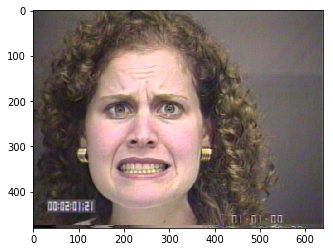

In [59]:
imtry='E:/CMU/approach1_april_10/data/CK+/cohn-kanade-images/S999/003\S999_003_00000055.png'
print 'file we are using is : ', imtry
imload=plt.imread(imtry)
print 'shape is: ', imload.shape
plt.imshow(imload)
list_out= alignAndcrop(imtry)
# imtry2=[3]
# hist= alignAndcrop(imtry)[2]
# print imtry2
# imload2=plt.imread('E:\CMU\approach1_april_10\data\cropped\S999_003_00000055.png')

# plt.imshow(alignAndcrop(imtry)[3])
# a=alignAndcrop(imtry)


In [40]:
import pickle

In [41]:
with open("data/histList.txt", "rb") as fp:
    histList=pickle.load(fp)

In [42]:
len(histList)

327

#### Function to check in which subj/seq is a particular FAU present above a threshold (between 1.0 and 5.0)

In [43]:
list_reqd_FAU=[]
i=0
j=0
for k,v in dict_file_FAU.iteritems():
    FAU_id=2.0
    FAU_threshold=3.0
    if FAU_id in v.keys():
            i+=1
            if (v[FAU_id]>=FAU_threshold):
                j+=1
                list_reqd_FAU.append(k)
                print k, ' has FAU ', FAU_id ,' value as ', v[FAU_id]          
print "This FAU is present in ", i
print "It is equal or above threshold in ", j
print "list_reqd_FAU has these many elements: ", len(list_reqd_FAU)

S506/004  has FAU  2.0  value as  4.0
S090/002  has FAU  2.0  value as  4.0
S085/003  has FAU  2.0  value as  3.0
S056/003  has FAU  2.0  value as  4.0
S060/003  has FAU  2.0  value as  4.0
S051/002  has FAU  2.0  value as  4.0
S132/008  has FAU  2.0  value as  3.0
S125/007  has FAU  2.0  value as  3.0
S126/004  has FAU  2.0  value as  4.0
S125/006  has FAU  2.0  value as  3.0
S068/003  has FAU  2.0  value as  3.0
This FAU is present in  116
It is equal or above threshold in  11
list_reqd_FAU has these many elements:  11


##### list_reqd_FAU has elements in this format: ['S006/001']

#### Viualising the selected FAUs:

E:/CMU/approach1_april_10/data/CK+/cohn-kanade-images/S085/003\S085_003_00000013.png
E:/CMU/approach1_april_10/data/CK+/cohn-kanade-images/S125/007\S125_007_00000009.png
E:/CMU/approach1_april_10/data/CK+/cohn-kanade-images/S132/008\S132_008_00000010.png
E:/CMU/approach1_april_10/data/CK+/cohn-kanade-images/S132/008\S132_008_00000010.png


Text(0.5,0.98,u'FAU: 2.0 outer brow raise')

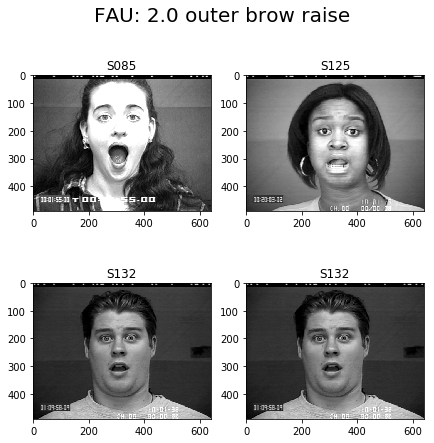

In [87]:
im1=(glob.glob(ck_original_path+list_reqd_FAU[np.random.randint(len(list_reqd_FAU))]+'/*.png')[-1])
print im1
im2=(glob.glob(ck_original_path+list_reqd_FAU[np.random.randint(len(list_reqd_FAU))]+'/*.png')[-1])
print im2
im3=(glob.glob(ck_original_path+list_reqd_FAU[np.random.randint(len(list_reqd_FAU))]+'/*.png')[-1])
print im3
im4=(glob.glob(ck_original_path+list_reqd_FAU[np.random.randint(len(list_reqd_FAU))]+'/*.png')[-1])
print im4
f, axarr = plt.subplots(2,2, figsize=(7,7))
axarr[0,0].imshow(mpimg.imread(im1),cmap='gray')
axarr[0,0].title.set_text(im1.split('/')[-2])
axarr[0,1].imshow(mpimg.imread(im2),cmap='gray')
axarr[0,1].title.set_text(im2.split('/')[-2])
axarr[1,0].imshow(mpimg.imread(im3),cmap='gray')
axarr[1,0].title.set_text(im3.split('/')[-2])
axarr[1,1].imshow(mpimg.imread(im4),cmap='gray')
axarr[1,1].title.set_text(im4.split('/')[-2])
f.suptitle('FAU: '+str(2.0)+' outer brow raise',fontsize=20)

# Defining and training ML models

##### Importing libraries

In [88]:
from sklearn.svm import SVC

# Features

#### 1. HOG only- Setting training and test data from histList and dict_file_FAU

In [89]:
hog_train_data=np.array([histList[i][2] for i in range(len(histList))])
hog_train_data=np.squeeze(hog_train_data,axis=2)

#### 2. HOG with PCA only- Setting training and test data from histList and dict_file_FAU

In [ ]:
hog_train_data2=np.array([histList[i][2] for i in range(len(histList))])
hog_train_data2=np.squeeze(hog_train_data,axis=2)

#### 3. Landmarks only

#### 4. HOG with landmarks- Setting training and test data from histList and dict_file_FAU

In [18]:
hog_train_data3=np.array([histList[i][2] for i in range(len(histList))])
hog_train_data3=np.squeeze(hog_train_data,axis=2)

##### Let's try out on FAUs such as 2.0, the following cell marks the labels for hogs

In [19]:
fau_id=2.0
fau_thresh=2.0
hog_labels=[]
for subj_seq_hist in histList:
    FAU_dict=dict_file_FAU[subj_seq_hist[0]+'/'+subj_seq_hist[1]]
    if fau_id in FAU_dict:
        if FAU_dict[fau_id]>fau_thresh:
            hog_labels.append(1)
        else:
            hog_labels.append(0)
    else:
        hog_labels.append(0)
hog_labels=np.array(hog_labels)
print 'the hog_labels are loaded; 1 category number: ', np.count_nonzero(hog_labels) 

the hog_labels are loaded; 1 category number:  11


In [20]:
hog_train_data.shape

(327L, 26244L)

In [21]:
len(hog_labels)

327

#### Just HOG

In [22]:
# hog_train_data

## SVM

In [23]:
clf=SVC()
clf.fit(hog_train_data, hog_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [54]:
cv=cross_validation.KFold(len(hog_train_data),n_folds=10,shuffle=True)

svm_results=[]
count=0
for traincv, testcv in cv:
#     print len(traincv),len(testcv)
    print 'confusion matrix for iteration: ',count
    count+=1
    res=clf.fit(hog_train_data[traincv],hog_labels[traincv]).predict(hog_train_data[testcv])
    print metrics.confusion_matrix(hog_labels[testcv],res)
#     print res
#     probas=forest_model.fit(hog_train_data[traincv],hog_labels[traincv]).predict_proba(hog_train_data[testcv])
#     print probas
#     metrics.confusion_matrix()
#     forest_results.append(metrics.accuracy_score(hog_labels))

confusion matrix for iteration:  0
[[31  0]
 [ 2  0]]
confusion matrix for iteration:  1
[[33]]
confusion matrix for iteration:  2
[[32  0]
 [ 1  0]]
confusion matrix for iteration:  3
[[33]]
confusion matrix for iteration:  4
[[32  0]
 [ 1  0]]
confusion matrix for iteration:  5
[[32  0]
 [ 1  0]]
confusion matrix for iteration:  6
[[32  0]
 [ 1  0]]
confusion matrix for iteration:  7
[[30  0]
 [ 2  0]]
confusion matrix for iteration:  8
[[31  0]
 [ 1  0]]
confusion matrix for iteration:  9
[[30  0]
 [ 2  0]]


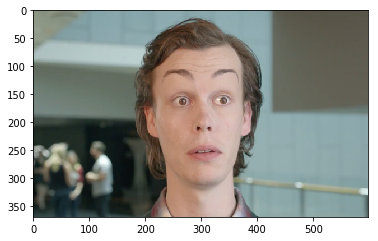

In [48]:
#this is a trial image with surprised emotion
tryIm=mpimg.imread('E:/CMU/approach1_april_10/data/fau2_im2.png')
plt.imshow(tryIm)
clf.fit

output shape is:  (112L, 112L, 3L) [ 0.75404412  0.75404412  0.75404412] [ 192.28125  192.28125  192.28125]


array([0])

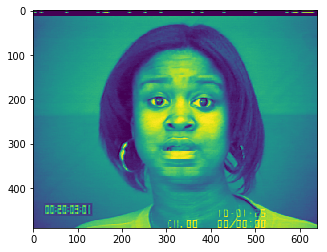

In [50]:
plt.imshow(mpimg.imread('E:/CMU/approach1_april_10/data/CK+/cohn-kanade-images/S125/007\S125_007_00000008.png'))
reqdHist=alignAndcrop('E:/CMU/approach1_april_10/data/CK+/cohn-kanade-images/S125/007\S125_007_00000008.png')[2]
reqdHist=np.squeeze(reqdHist,axis=1)
reqdHist.shape
clf.predict([reqdHist]).pro

In [26]:
clf.predict(hog_train_data)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

## Decision Tree

In [27]:
from sklearn import tree
tree_model=tree.DecisionTreeClassifier(criterion='gini')

In [28]:
tree_model.fit(hog_train_data,hog_labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [53]:
cv=cross_validation.KFold(len(hog_train_data),n_folds=10,shuffle=True)

dtree_results=[]
count=0
for traincv, testcv in cv:
#     print len(traincv),len(testcv)
    print 'confusion matrix for iteration: ',count
    count+=1
    res=tree_model.fit(hog_train_data[traincv],hog_labels[traincv]).predict(hog_train_data[testcv])
    print metrics.confusion_matrix(hog_labels[testcv],res)
    print res
    print hog_labels[testcv]
#     probas=forest_model.fit(hog_train_data[traincv],hog_labels[traincv]).predict_proba(hog_train_data[testcv])
#     print probas
#     metrics.confusion_matrix()
#     forest_results.append(metrics.accuracy_score(hog_labels))

confusion matrix for iteration:  0
[[30  3]
 [ 0  0]]
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
confusion matrix for iteration:  1
[[27  5]
 [ 1  0]]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
confusion matrix for iteration:  2
[[30  2]
 [ 1  0]]
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
confusion matrix for iteration:  3
[[32  1]
 [ 0  0]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
confusion matrix for iteration:  4
[[32  1]
 [ 0  0]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
confusion matrix for iteration:  5
[[30  1]
 [ 2  

In [29]:
np.count_nonzero(hog_labels)

11

In [30]:
tree_predictions=tree_model.predict(hog_train_data)
print 'tree predictions are: ', tree_predictions
np.count_nonzero(tree_predictions)

tree predictions are:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]


11

## Random Forest

In [56]:
from sklearn import cross_validation
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
forest_model=RandomForestClassifier(n_estimators=1000)

In [57]:
cv=cross_validation.KFold(len(hog_train_data),n_folds=10,shuffle=True)

dtree_results=[]
count=0
for traincv, testcv in cv:
#     print len(traincv),len(testcv)
    print 'confusion matrix for iteration: ',count
    count+=1
    res=forest_model.fit(hog_train_data[traincv],hog_labels[traincv]).predict(hog_train_data[testcv])
    print metrics.confusion_matrix(hog_labels[testcv],res)
    print res
    print hog_labels[testcv]
#     probas=forest_model.fit(hog_train_data[traincv],hog_labels[traincv]).predict_proba(hog_train_data[testcv])
#     print probas
#     metrics.confusion_matrix()
#     forest_results.append(metrics.accuracy_score(hog_labels))

confusion matrix for iteration:  0
[[32  0]
 [ 1  0]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
confusion matrix for iteration:  1
[[33]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
confusion matrix for iteration:  2
[[32  0]
 [ 1  0]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
confusion matrix for iteration:  3
[[31  0]
 [ 2  0]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
confusion matrix for iteration:  4
[[31  0]
 [ 2  0]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
confusion matrix for iteration:  5
[[30  0]
 [ 3  0]]
[0 0 0 0

In [37]:
forest_predictions=forest_model.predict(hog_train_data)
print 'forest predictions are: ', forest_predictions
np.count_nonzero(forest_predictions)

forest predictions are:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]


11

## Classification metrics

In [34]:
from sklearn.cross_validation import KFold
from sklearn import metrics

## Neural Network

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

Using Theano backend.



You can find the C code in this temporary file: c:\users\amoghg~1\appdata\local\temp\theano_compilation_error_im0gct


Exception: Compilation failed (return status=1): C:\Users\AMOGHG~1\AppData\Local\Temp\cc9FNLN5.o: In function `unpack_list_of_ssize_t':. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:48: undefined reference to `__imp_PyExc_TypeError'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:58: undefined reference to `__imp_PyExc_IndexError'. C:\Users\AMOGHG~1\AppData\Local\Temp\cc9FNLN5.o: In function `CLazyLinker_init':. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:331: undefined reference to `__imp_PyCObject_Type'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:352: undefined reference to `__imp_PyExc_IndexError'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:370: undefined reference to `__imp_PyExc_IndexError'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:385: undefined reference to `__imp_PyExc_IndexError'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:389: undefined reference to `__imp_PyExc_IndexError'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:393: undefined reference to `__imp_PyExc_IndexError'. C:\Users\AMOGHG~1\AppData\Local\Temp\cc9FNLN5.o:C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:397: more undefined references to `__imp_PyExc_IndexError' follow. C:\Users\AMOGHG~1\AppData\Local\Temp\cc9FNLN5.o: In function `CLazyLinker_init':. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:405: undefined reference to `__imp_PyExc_TypeError'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:420: undefined reference to `__imp__Py_NoneStruct'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:426: undefined reference to `__imp_PyExc_IndexError'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:440: undefined reference to `__imp_PyExc_TypeError'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:444: undefined reference to `__imp__Py_NoneStruct'. C:\Users\AMOGHG~1\AppData\Local\Temp\cc9FNLN5.o: In function `c_call':. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:545: undefined reference to `__imp__Py_NoneStruct'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:545: undefined reference to `__imp__Py_NoneStruct'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:545: undefined reference to `__imp__Py_NoneStruct'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:546: undefined reference to `__imp__Py_NoneStruct'. C:\Users\AMOGHG~1\AppData\Local\Temp\cc9FNLN5.o:C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:546: more undefined references to `__imp__Py_NoneStruct' follow. C:\Users\AMOGHG~1\AppData\Local\Temp\cc9FNLN5.o: In function `lazy_rec_eval':. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:618: undefined reference to `__imp_PyExc_IndexError'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:641: undefined reference to `__imp_PyExc_TypeError'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:649: undefined reference to `__imp_PyExc_ValueError'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:657: undefined reference to `__imp_PyExc_IndexError'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:708: undefined reference to `__imp__Py_NoneStruct'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:715: undefined reference to `__imp_PyExc_TypeError'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:721: undefined reference to `__imp_PyExc_TypeError'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:771: undefined reference to `__imp__Py_NoneStruct'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:771: undefined reference to `__imp__Py_NoneStruct'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:772: undefined reference to `__imp__Py_NoneStruct'. C:\Users\AMOGHG~1\AppData\Local\Temp\cc9FNLN5.o: In function `CLazyLinker_call':. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:814: undefined reference to `__imp_PyExc_RuntimeError'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:826: undefined reference to `__imp_PyExc_RuntimeError'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:839: undefined reference to `__imp__Py_NoneStruct'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:839: undefined reference to `__imp__Py_NoneStruct'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:840: undefined reference to `__imp__Py_NoneStruct'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:849: undefined reference to `__imp__Py_NoneStruct'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:849: undefined reference to `__imp__Py_NoneStruct'. C:\Users\AMOGHG~1\AppData\Local\Temp\cc9FNLN5.o:C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:850: more undefined references to `__imp__Py_NoneStruct' follow. C:\Users\AMOGHG~1\AppData\Local\Temp\cc9FNLN5.o: In function `CLazyLinker_call':. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:894: undefined reference to `__imp_PyExc_AssertionError'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:937: undefined reference to `__imp__Py_NoneStruct'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:937: undefined reference to `__imp__Py_NoneStruct'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:938: undefined reference to `__imp__Py_NoneStruct'. C:\Users\AMOGHG~1\AppData\Local\Temp\cc9FNLN5.o: In function `CLazyLinker_set_allow_gc':. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:973: undefined reference to `__imp_PyBool_Type'. C:/Users/AMOGH GUPTA/AppData/Local/Theano/compiledir_Windows-10-10.0.16299-Intel64_Family_6_Model_61_Stepping_4_GenuineIntel-2.7.14-64/lazylinker_ext/mod.cpp:976: undefined reference to `__imp__Py_TrueStruct'. collect2.exe: error: ld returned 1 exit status. 

In [5]:
simple_model=keras.Sequential()
simple_model.add(Dense(512,activation='relu', input_shape=(12544,)))
simple_model.add(Dense(512, activation='relu'))
simple_model.add(Dense(2,activation='sigmoid'))
simple_model.summary()
simple_model.compile(loss='categorical_crossentropy',optimizer=RMSprop())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               6423040   
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 1026      
Total params: 6,686,722
Trainable params: 6,686,722
Non-trainable params: 0
_________________________________________________________________


## Relevant FAU to tutoring
#### 1 inner brow raiser

#### 2 outer brow raiser

#### 4 brow lowerer

#### 5 upper lid raiser

#### 7 lid tightener

#### 25 lips part

#### 26 jaw drop

In [37]:
# Trying to see things on data 

Text(0.5,0.98,u'no warping')

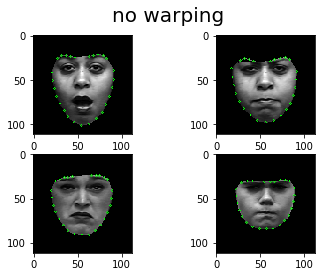

In [107]:
img_to_view_array=[]
for i in range(40):
    img=mpimg.imread('E:/CMU/approach1_april_10/data/cropped/'+os.listdir('E:/CMU/approach1_april_10/data/cropped/')[np.random.randint(20)])
    img_to_view_array.append(img)
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(img_to_view_array[np.random.randint(30)])
axarr[0,1].imshow(img_to_view_array[np.random.randint(30)])
axarr[1,0].imshow(img_to_view_array[np.random.randint(30)])
axarr[1,1].imshow(img_to_view_array[np.random.randint(30)])
f.suptitle('no warping',fontsize=20)

Text(0.5,0.98,u'landmarks upto 36 used to warp')

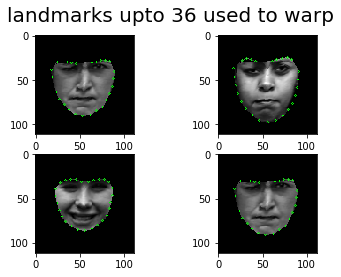

In [93]:
img_to_view_array=[]
for i in range(40):
    img=mpimg.imread('E:/CMU/approach1_april_10/data/cropped/'+os.listdir('E:/CMU/approach1_april_10/data/cropped/')[np.random.randint(20)])
    img_to_view_array.append(img)

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(img_to_view_array[np.random.randint(30)])
axarr[0,1].imshow(img_to_view_array[np.random.randint(30)])
axarr[1,0].imshow(img_to_view_array[np.random.randint(30)])
axarr[1,1].imshow(img_to_view_array[np.random.randint(30)])
f.suptitle('landmarks upto 36 used to warp',fontsize=20)

# Things to try that might improve the model performance
#### Include some other landmarks while warping so that the face can align better, for now just the outer ones are fine, in fact no warping seems better. We can move to Procrustes in future
#### Checking between grayscale and color in CK+

In [28]:
histList.shape

AttributeError: 'list' object has no attribute 'shape'

In [63]:
from sklearn import decomposition

In [162]:
x=np.array([[4.,3.,5.,6.,9.,9.,9.],[2.,4.,7.,6.,9.,9.,9.],[1.,2.,7.,5.,9.,9.,9.]])

In [163]:
pca=decomposition.PCA(n_components=5)

In [164]:
pca.fit(x)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [165]:
x=pca.transform(x)
x.shape

(3L, 3L)

In [145]:
327*26244

8581788

In [135]:
hog_train_data=hog_train_data.reshape(327,26244)
hog_train_data.shape

(327L, 26244L)

In [136]:
np.count_nonzero(hog_train_data)

2803906

In [137]:
hog_train_data

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [138]:
hog_train_data.shape

(327L, 26244L)

In [139]:
pca2=decomposition.PCA(n_components=20000)
pca2.fit(hog_train_data)
hog_pca_train_data=pca2.transform(hog_train_data)

In [140]:
hog_pca_train_data.shape

(327L, 327L)